## Processing Ocean Color Imagery - Process Micasense Images

Pull in all images and process with micasense tools
    normalize and align and whatnot
    put these into functions and clean up
    also visualize along the way and look at distributions to think about whether or not they're legitimate
    write out
    
Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
from georeg import *

### Run the process

#### Now the real processing code

In [3]:
! ls data/20210317_duml_360_altitude_testing/altitude_test

000  diag.dat	  IMG_0100_1.txt  panel		thumbnails
001  gpslog.dat   IMG_0105_1.txt  paramlog.dat	varying_altitude
002  hostlog.dat  new.txt	  stacks	xy_coords


In [4]:
glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0002*.tif'))

['data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_5.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_2.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_6.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_4.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_3.tif',
 'data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002_1.tif']

I'm using the panel from the flight 1 hour before this one, the one we took for this flight was too close and unusable. This day was totally overcast and not changing much so this should be appropriate.

In [5]:
panelNames = None
#panelNames = glob.glob(os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'panel', 'IMG_0002_*.tif'))
alt_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude')

warp_img_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude', 'align_img')

altitude_out = process_micasense_subset(alt_dir, panelNames, warp_img_dir, overwrite=False)

Not using panel irradiance.
used warp dir data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 3
Finished aligning band 4
Finished aligning band 1
Saving time: 0:17:27.433793
Alignment+Saving rate: 0.32 images per second
Finished saving images.
exiftool -csv="data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/log.csv" -overwrite_original data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks
Finished saving image metadata.


In [6]:
! exiftool -csv="data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks/log.csv" -overwrite_original data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/stacks

    1 directories scanned
  338 image files updated


In [ ]:
Comparing the DLS irradiance to the panel irradiance

In [12]:
imgset.images

AttributeError: 'ImageSet' object has no attribute 'images'

In [9]:
imgset = imageset.ImageSet.from_directory(alt_dir)

In [24]:
imgset.captures[0].images[0].exposure_time

0.001315877

(0.0, 0.002)

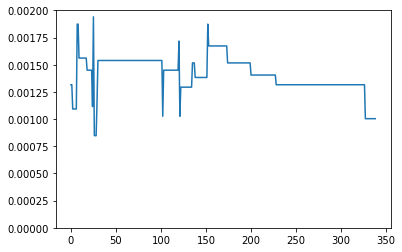

In [28]:
plt.plot(exposures)
plt.ylim(0,0.002)

In [64]:
dls_ed = []
exposures = []
gains = []
for cap in imgset.captures:
    if len(cap.dls_irradiance()) == 6:
        dls_ed.append(np.array(cap.dls_irradiance()))
        exp = []
        gain_cap = []
        for img in cap.images: 
            exp.append(img.exposure_time)
            gain_cap.append(img.gain)
        exposures.append(exp)
        gains.append(gain_cap)
        
exposures = np.array(exposures)
gains = np.array(gains)
dls_ed = np.array(dls_ed)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/

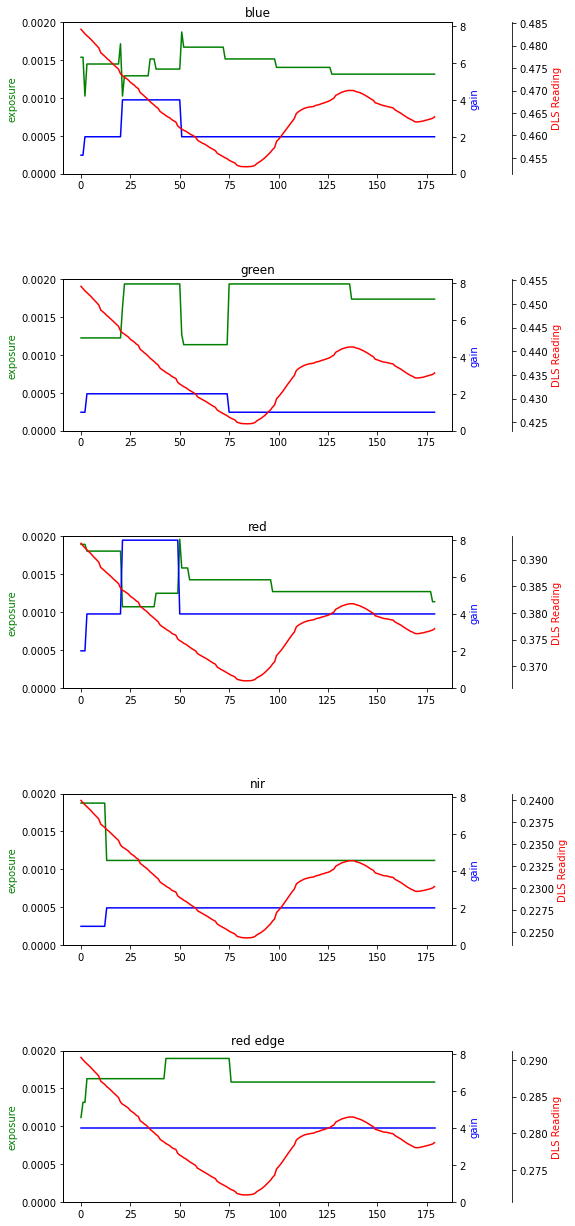

In [94]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']

fig, ax = plt.subplots(5,1, figsize=(12,18))

for i in range(5):
    ax[i].plot(exposures[100:280,i], color='green')
    ax[i].set_ylim(0,.002)
    ax2 = ax[i].twinx()
    ax2.plot(gains[100:280,i], color='blue')
    ax2.set_ylim(0,8.2)
    ax3 = ax[i].twinx()
    ax3.plot(dls_ed[100:280,i], color='red')
#     ax3.set_ylim(.22,.5)
    ax3.spines['right'].set_position(('outward', 60))
    
    ax[i].set_ylabel('exposure')
    ax2.set_ylabel('gain')
    ax3.set_ylabel('DLS Reading')
    
    ax[i].yaxis.label.set_color('green')
    ax2.yaxis.label.set_color('blue')
    ax3.yaxis.label.set_color('red')
    
    ax[i].set_title(band_names[i])
    fig.tight_layout()
    fig.savefig('gain_exposure_dls.png',dpi=300)
    fig.show()
#     

In [ ]:
dls_ed = []
gains = []
for cap in imgset.captures:
    if len(cap.dls_irradiance()) == 6:
        dls_ed.append(np.array(cap.dls_irradiance()))
        exp = []
        for img in cap.images: 
            exp.append(img.gain)
        exposures.append(exp)
        
exposures = np.array(exposures)

In [70]:
dls_ed

[array([0.50339357, 0.47135883, 0.40823212, 0.24915264, 0.30185853,
        0.        ]),
 array([0.50403024, 0.4719828 , 0.40879321, 0.24949901, 0.30227274,
        0.        ]),
 array([0.50492856, 0.47285625, 0.40957722, 0.24997585, 0.30284585,
        0.        ]),
 array([0.50560016, 0.47349255, 0.41013591, 0.25031545, 0.30325679,
        0.        ]),
 array([0.5064043 , 0.47427232, 0.41083954, 0.2507489 , 0.30377827,
        0.        ]),
 array([0.50732001, 0.47513321, 0.41160971, 0.25121133, 0.30434016,
        0.        ]),
 array([0.5080523 , 0.47583753, 0.41224494, 0.25159343, 0.30480421,
        0.        ]),
 array([0.50893787, 0.47670735, 0.41303743, 0.25207533, 0.3053743 ,
        0.        ]),
 array([0.50965088, 0.47739948, 0.41365331, 0.2524516 , 0.30582922,
        0.        ]),
 array([0.51042584, 0.47814337, 0.41432381, 0.25286475, 0.30633574,
        0.        ]),
 array([0.51223116, 0.47987884, 0.41589886, 0.25381591, 0.3074857 ,
        0.        ]),
 array([0.

In [76]:
! ls data/20210317_duml_360_altitude_testing/altitude_test/panel

IMG_0002_1.tif	IMG_0002_5.tif	IMG_0494_3.tif	IMG_0495_1.tif	IMG_0495_5.tif
IMG_0002_2.tif	IMG_0002_6.tif	IMG_0494_4.tif	IMG_0495_2.tif	IMG_0495_6.tif
IMG_0002_3.tif	IMG_0494_1.tif	IMG_0494_5.tif	IMG_0495_3.tif
IMG_0002_4.tif	IMG_0494_2.tif	IMG_0494_6.tif	IMG_0495_4.tif


In [79]:
dls_ed = np.array(dls_ed)

In [80]:
dls_ed.shape

(338, 6)

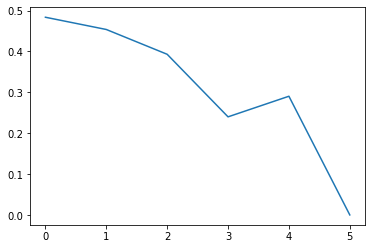

In [97]:
plt.plot(dls_ed[100,:])

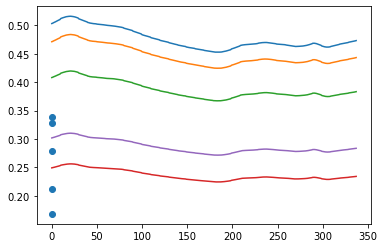

In [100]:
plt.plot(dls_ed[:,0])
plt.plot(dls_ed[:,1])
plt.plot(dls_ed[:,2])
plt.plot(dls_ed[:,3])
plt.plot(dls_ed[:,4])
plt.scatter([0,0,0,0,0],irr_from_panel)

In [85]:
panel_cap = capture.Capture.from_filelist(glob.glob('data/20210317_duml_360_altitude_testing/altitude_test/panel/IMG_0002*'))

In [98]:
panel_reflectance_by_band = [.539,.539,.538,.534,.537]#[0.493, 0.493, 0.492, 0.489, 0.491] #[0.67, 0.69, 0.68, 0.61, 0.67]

panel_radiances = np.array(panel_cap.panel_radiance())
irr_from_panel = math.pi * panel_radiances / panel_reflectance_by_band

In [99]:
irr_from_panel

array([0.32822018, 0.33827115, 0.27919627, 0.16799613, 0.21271497])

In [ ]:
Rrs = Lt / Ed